In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb

In [15]:
df = pd.read_csv('movies_model_ready.csv')

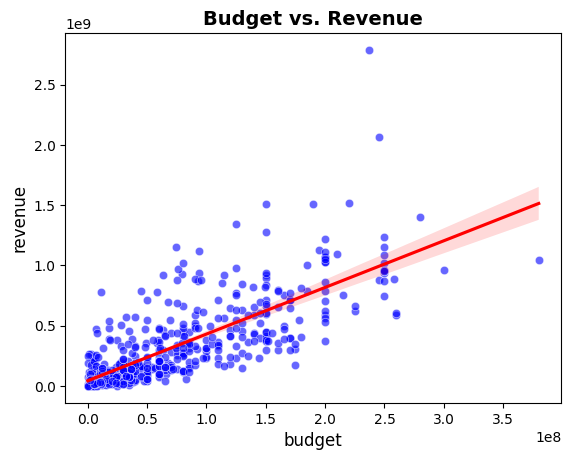

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=df, x='budget', y='revenue', alpha=0.6, color='blue')
plt.title('Budget vs. Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Budget ($)', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
sns.regplot(data=df, x='budget', y='revenue', scatter=False, color='red')
plt.show()

Text(0.5, 1.0, 'Feature Correlation Matrix')

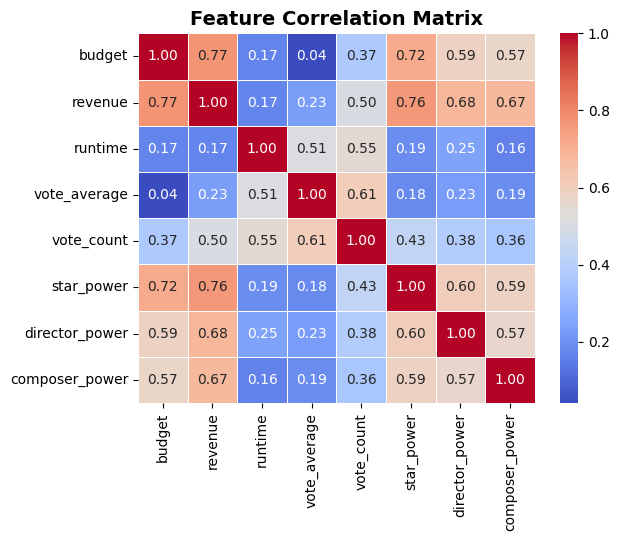

In [30]:
numeric_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 
                'star_power', 'director_power', 'composer_power']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

Text(0, 0.5, 'Number of Movies')

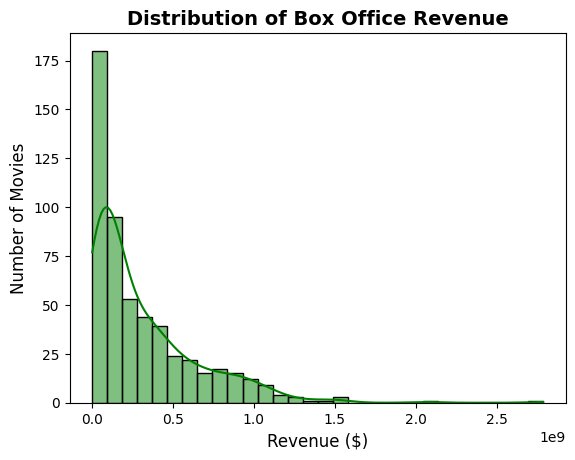

In [32]:
sns.histplot(df['revenue'], kde=True, color='green', bins=30)
plt.title('Distribution of Box Office Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Revenue ($)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

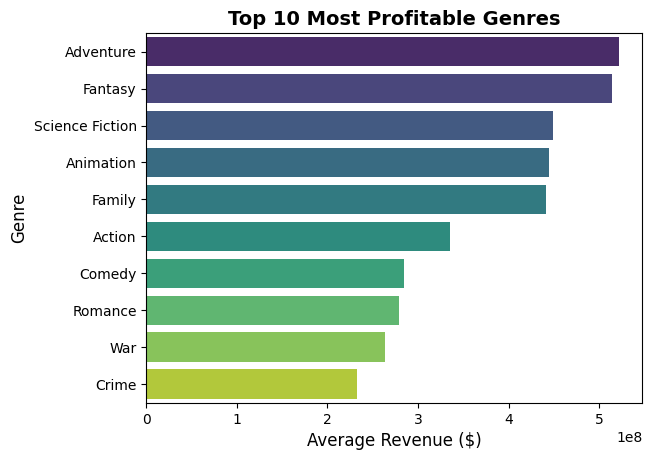

In [37]:
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
genre_revenues = {}

for col in genre_cols:
    # Get the average revenue for movies that have this genre (where value is 1)
    avg_rev = df[df[col] == 1]['revenue'].mean()
    genre_name = col.replace('Genre_', '')
    genre_revenues[genre_name] = avg_rev

# Convert to DataFrame and sort
genre_df = pd.DataFrame(list(genre_revenues.items()), columns=['Genre', 'Avg_Revenue'])
genre_df = genre_df.sort_values(by='Avg_Revenue', ascending=False).head(10)

sns.barplot(data=genre_df, x='Avg_Revenue', y='Genre', hue='Genre', palette='viridis', legend=False)
plt.title('Top 10 Most Profitable Genres', fontsize=14, fontweight='bold')
plt.xlabel('Average Revenue ($)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

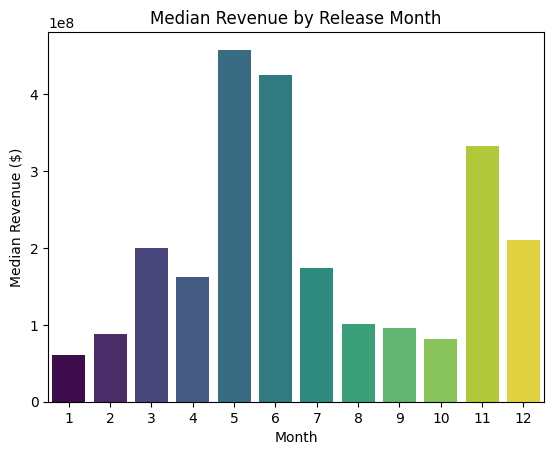

In [38]:
month_rev = df.groupby('release_month')['revenue'].median()
sns.barplot(x=month_rev.index, y=month_rev.values, palette='viridis', hue=month_rev.index, legend=False)
plt.title('Median Revenue by Release Month', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Median Revenue ($)')
plt.show()

In [16]:
y = df['revenue']
X = df.drop(['revenue'], axis=1)

In [17]:
X.shape

(539, 29)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [20]:
results = []
for name, model in models.items():
    print(f"{name}...", end=" ")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({'Model': name, 'R2 Score': r2, 'MAE': mae})

Linear Regression... Decision Tree... Random Forest... Gradient Boosting... XGBoost... 

In [21]:
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

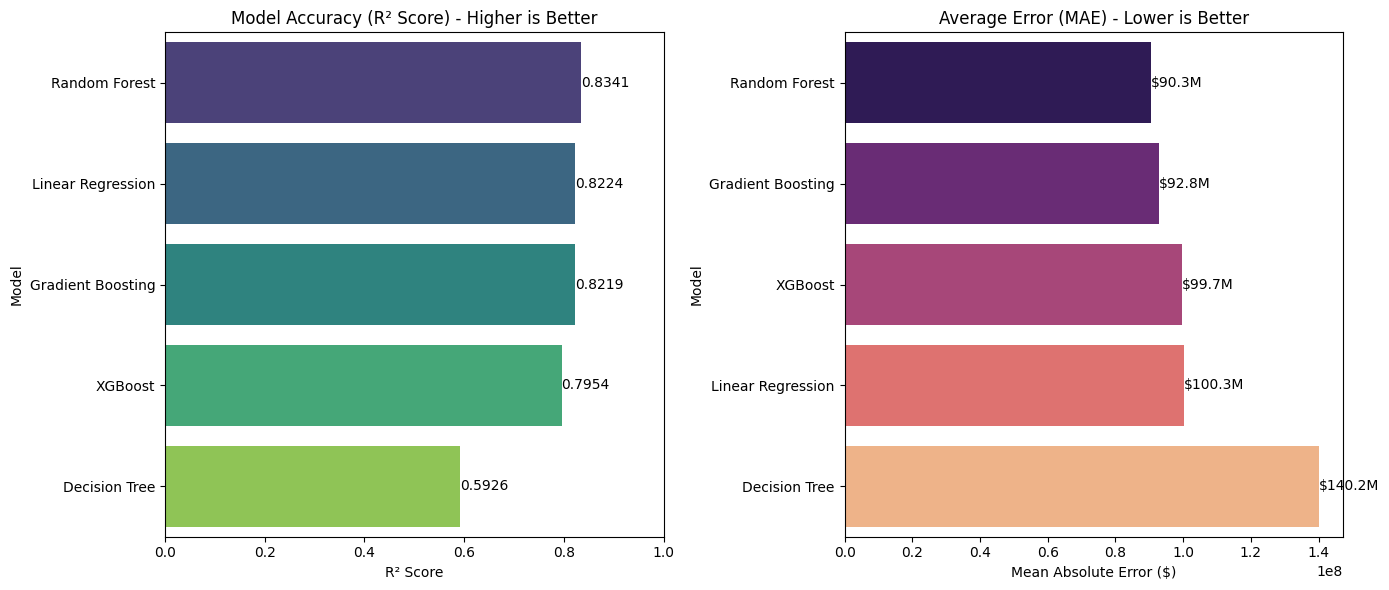

In [22]:
plt.figure(figsize=(14, 6))

# Plot 1: R2 Score
plt.subplot(1, 2, 1)
# FIX: Added hue='Model' and legend=False
sns.barplot(x='R2 Score', y='Model', data=results_df, hue='Model', legend=False, palette='viridis')
plt.title('Model Accuracy (R² Score) - Higher is Better')
plt.xlabel('R² Score')
plt.xlim(0, 1.0)
for index, value in enumerate(results_df['R2 Score']):
    plt.text(value, index, f'{value:.4f}', va='center')

# Plot 2: MAE
plt.subplot(1, 2, 2)
# FIX: Added hue='Model' and legend=False
sns.barplot(x='MAE', y='Model', data=results_df.sort_values(by='MAE'), hue='Model', legend=False, palette='magma')
plt.title('Average Error (MAE) - Lower is Better')
plt.xlabel('Mean Absolute Error ($)')
for index, value in enumerate(results_df.sort_values(by='MAE')['MAE']):
    plt.text(value, index, f'${value/1e6:.1f}M', va='center')

plt.tight_layout()
plt.show()

In [23]:
best_model = results_df.iloc[0]
best_model

Model         Random Forest
R2 Score           0.834093
MAE         90345134.516296
Name: 2, dtype: object

In [24]:
final_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [25]:
final_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [26]:
import pickle
with open('movie_revenue_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)